In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

In [111]:
def get_metrics(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'medAE: {median_absolute_error(y_true, y_pred)}')
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')
    print(f'MSLE: {mean_squared_log_error(y_true, y_pred)}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')

In [112]:
df = pd.read_csv('time series data.csv')

df.head()

,t,ProductP1,ProductP2,ProductP3,ProductP4,ProductP5,price,temperature
0,1,197,66,266,113,2,1,18
1,2,153,44,264,74,1,2,21
2,3,128,55,317,116,0,1,19
3,4,133,57,390,70,0,2,17
4,5,120,47,440,141,1,1,18


In [60]:
msk = (df.index < len(df) - int(0.2 * len(df)))
df_train = df[msk].copy()
df_test = df[~msk].copy()

<Axes: >

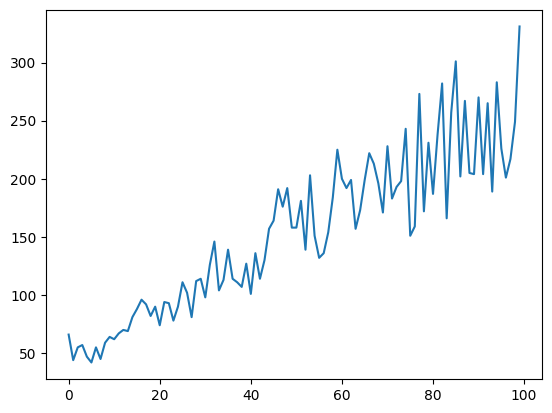

In [61]:
df['ProductP2'].plot()

In [62]:
fh = ForecastingHorizon(df_test['ProductP2'].index, is_relative = False)
fh

ForecastingHorizon([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
       98, 99],
      dtype='int64', is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='ProductP2'>)

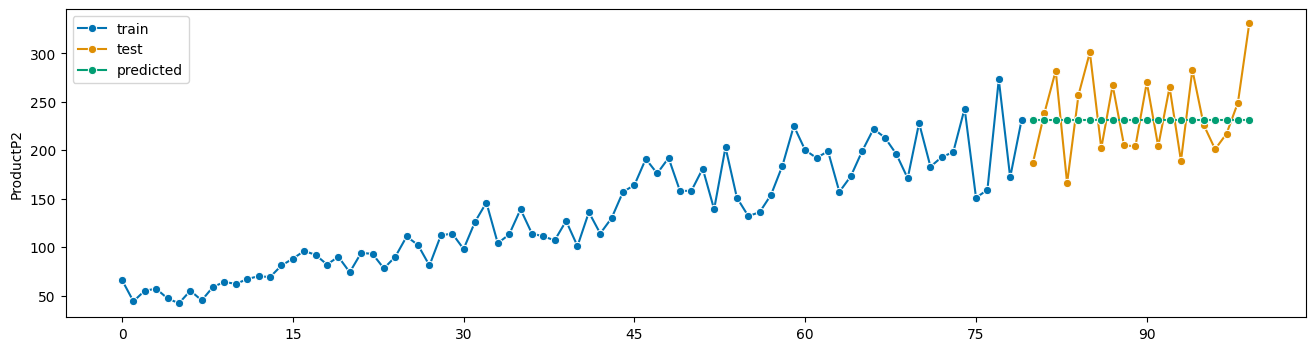

In [100]:
forecaster = NaiveForecaster(strategy = 'last')
forecaster.fit(df_train['ProductP2'])

y_pred = forecaster.predict(fh)

plot_series(df_train['ProductP2'], df_test['ProductP2'], y_pred, labels = ['train', 'test', 'predicted'])

In [101]:
get_metrics(df_test['ProductP2'], y_pred)

MAE: 37.1
medAE: 32.0
MSE: 1862.4
MSLE: 0.0319025571902431
MAPE: 15.648957423195494


MAE: 44.645
medAE: 36.0
MSE: 3388.1625
MSLE: 0.0592308685001246
MAPE: 16.89891018965373


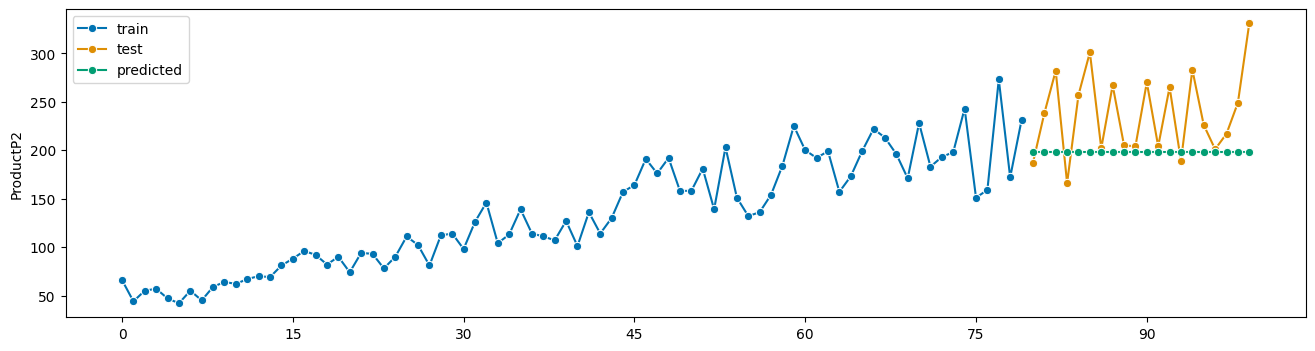

In [102]:
mapeforecaster = NaiveForecaster(strategy = 'mean', window_length = 20)
forecaster.fit(df_train['ProductP2'])

y_pred = forecaster.predict(fh)

plot_series(df_train['ProductP2'], df_test['ProductP2'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['ProductP2'], y_pred)

MAE: 62.55
medAE: 60.5
MSE: 4979.75
MSLE: 0.10265426140944298
MAPE: 26.15614288156683


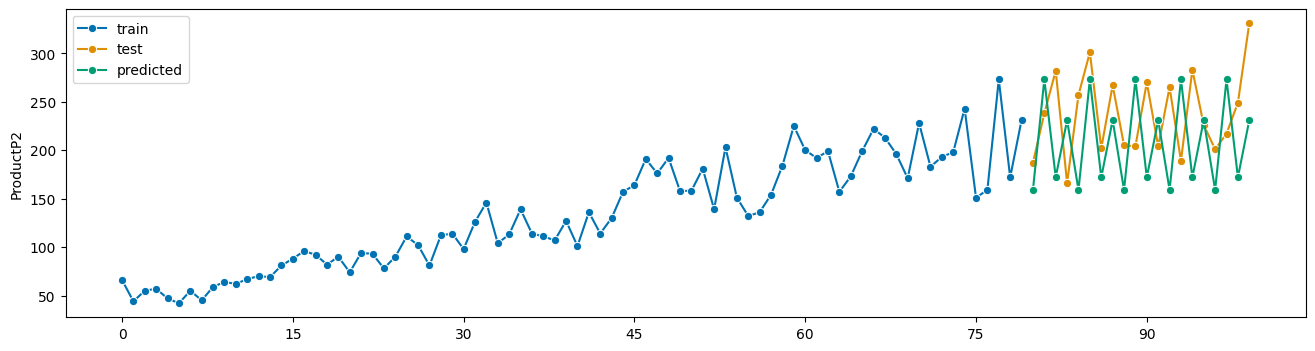

In [103]:
forecaster = NaiveForecaster(strategy = 'last', sp = 4)
forecaster.fit(df_train['ProductP2'])

y_pred = forecaster.predict(fh)

plot_series(df_train['ProductP2'], df_test['ProductP2'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['ProductP2'], y_pred)

MAE: 39.7260389465981
medAE: 35.13019473299045
MSE: 2655.14012834215
MSLE: 0.044581600204899915
MAPE: 15.293690297371624


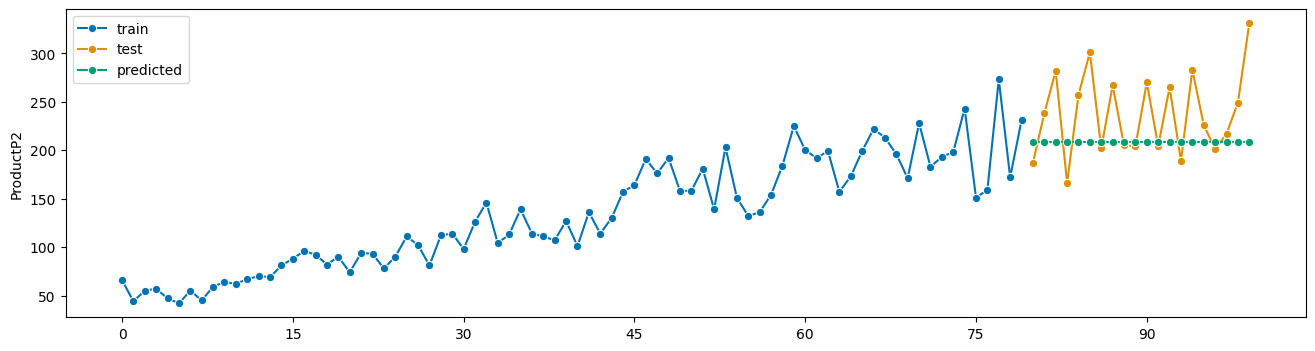

In [104]:
forecaster = ExponentialSmoothing()
forecaster.fit(df_train['ProductP2'])

y_pred = forecaster.predict(fh)

plot_series(df_train['ProductP2'], df_test['ProductP2'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['ProductP2'], y_pred)

MAE: 39.073083842750506
medAE: 35.07334057781756
MSE: 1817.5664388767843
MSLE: 0.032549658595986374
MAPE: 17.204763340062858


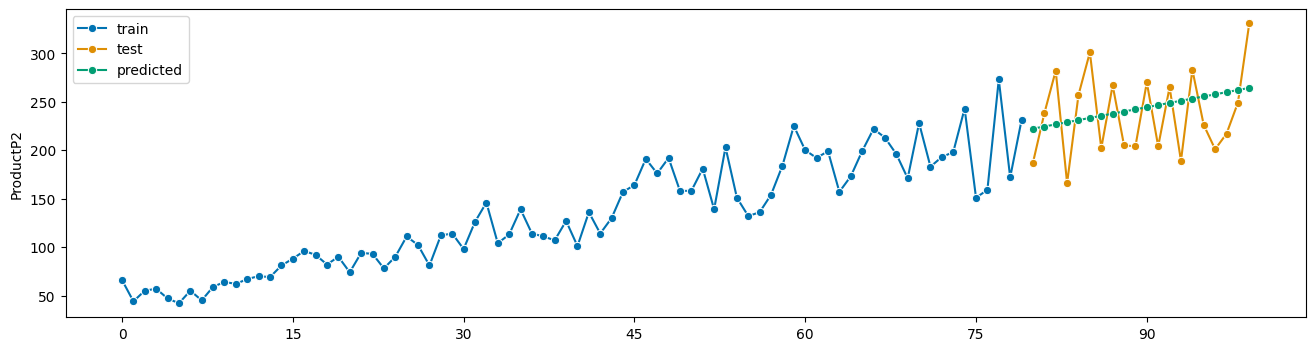

In [105]:
forecaster = ExponentialSmoothing(trend = 'add')
forecaster.fit(df_train['ProductP2'])

y_pred = forecaster.predict(fh)

plot_series(df_train['ProductP2'], df_test['ProductP2'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['ProductP2'], y_pred)

MAE: 38.90056624305508
medAE: 33.73942596533334
MSE: 1800.7780478879667
MSLE: 0.032102016315554115
MAPE: 17.037233779930364


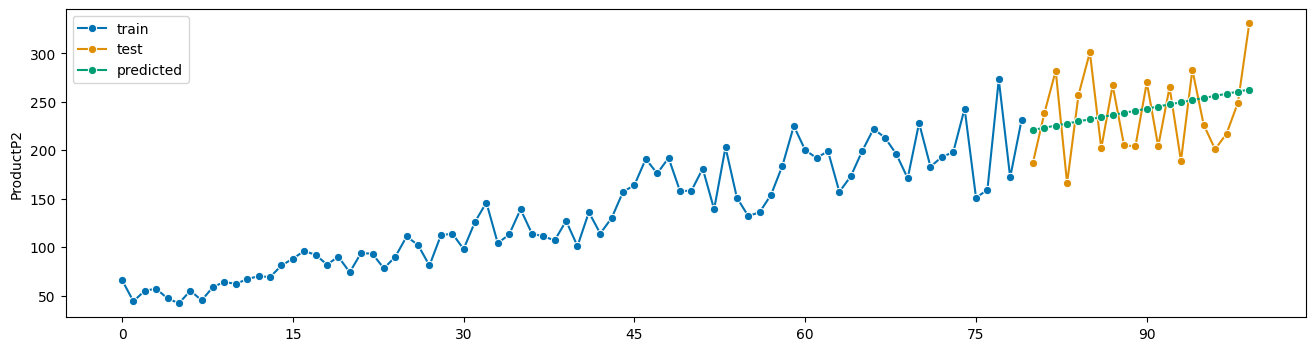

In [106]:
forecaster = AutoETS(auto = True, n_jobs = -1, information_criterion = 'bic', initial_trend = 'add')
forecaster.fit(df_train['ProductP2'])

y_pred = forecaster.predict(fh)

plot_series(df_train['ProductP2'], df_test['ProductP2'], y_pred, labels = ['train', 'test', 'predicted'])
get_metrics(df_test['ProductP2'], y_pred)

In [107]:
forecaster.get_params()

{'additive_only': False,
 'allow_multiplicative_trend': False,
 'auto': True,
 'bounds': None,
 'callback': None,
 'damped_trend': False,
 'dates': None,
 'disp': False,
 'error': 'add',
 'freq': None,
 'full_output': True,
 'ignore_inf_ic': True,
 'information_criterion': 'bic',
 'initial_level': None,
 'initial_seasonal': None,
 'initial_trend': 'add',
 'initialization_method': 'estimated',
 'maxiter': 1000,
 'missing': 'none',
 'n_jobs': -1,
 'random_state': None,
 'restrict': True,
 'return_params': False,
 'seasonal': None,
 'sp': 1,
 'start_params': None,
 'trend': None}

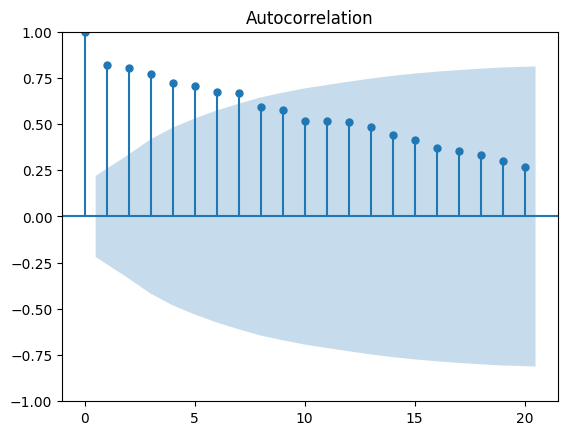

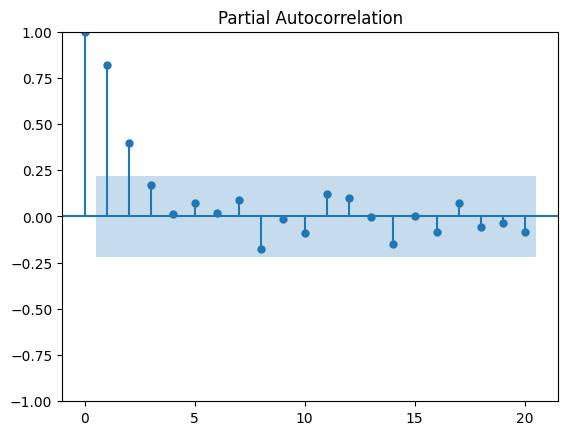

In [71]:
acf_original = plot_acf(df_train['ProductP2'])
plt.show()

pacf_original = plot_pacf(df_train['ProductP2'])
plt.show()

In [72]:
adf_test = adfuller(df_train['ProductP2'])
print(f'p-value: {adf_test[1]}')

p-value: 0.829617589607836


In [73]:
diff_data = df_train['ProductP2'].diff()
diff_data = diff_data.dropna()
diff_data.isna().sum()

0

In [74]:
adf_test = adfuller(diff_data)
print(f'p-value: {adf_test[1]}')

p-value: 1.1663151900765919e-05


<Axes: >

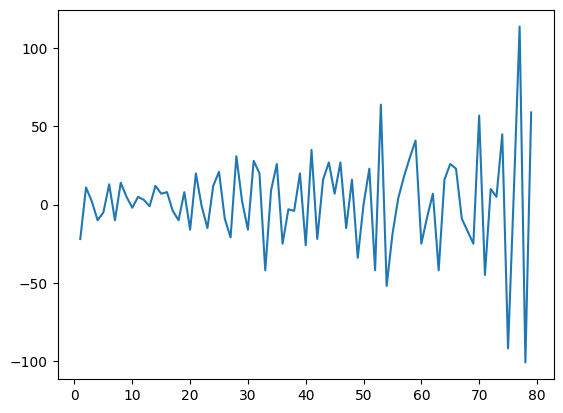

In [75]:
diff_data.plot()

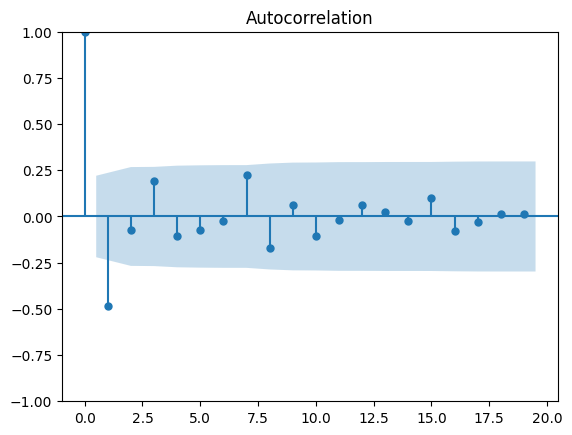

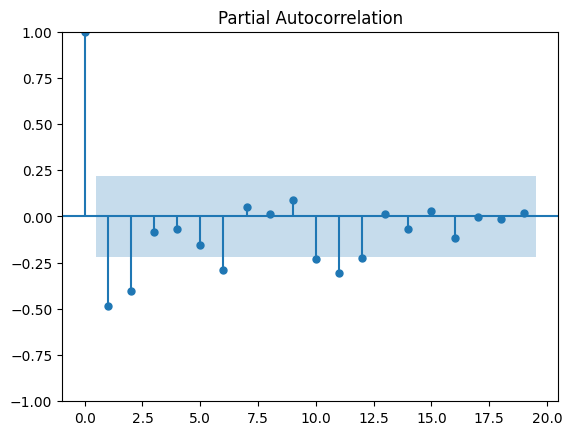

In [76]:
acf_original = plot_acf(diff_data)
plt.show()

pacf_original = plot_pacf(diff_data)
plt.show()

In [77]:
auto = auto_arima(df_train['ProductP2'], seasonal = False, stepwise = False)
print(auto)
print(auto.summary())

 ARIMA(2,1,0)(0,0,0)[0] intercept
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -364.911
Date:                Tue, 26 Mar 2024   AIC                            737.822
Time:                        23:58:28   BIC                            747.300
Sample:                             0   HQIC                           741.619
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4737      2.860      1.564      0.118      -1.131      10.078
ar.L1         -0.6902      0.080     -8.582      0.000      -0.848      -0.533
ar.L2         -0.4

In [78]:
auto = auto_arima(df_train['ProductP2'], seasonal = True, stepwise = False)
print(auto)
print(auto.summary())

 ARIMA(2,1,0)(0,0,0)[1] intercept
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -364.911
Date:                Tue, 26 Mar 2024   AIC                            737.822
Time:                        23:58:34   BIC                            747.300
Sample:                             0   HQIC                           741.619
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.4737      2.860      1.564      0.118      -1.131      10.078
ar.L1         -0.6902      0.080     -8.582      0.000      -0.848      -0.533
ar.L2         -0.4

In [108]:
model = ARIMA(df_train['ProductP2'], order = (2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              ProductP2   No. Observations:                   80
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -366.161
Date:                Wed, 27 Mar 2024   AIC                            738.322
Time:                        00:44:30   BIC                            745.431
Sample:                             0   HQIC                           741.170
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6716      0.085     -7.917      0.000      -0.838      -0.505
ar.L2         -0.4044      0.073     -5.558      0.000      -0.547      -0.262
sigma2       616.6120     85.140      7.242      0.0

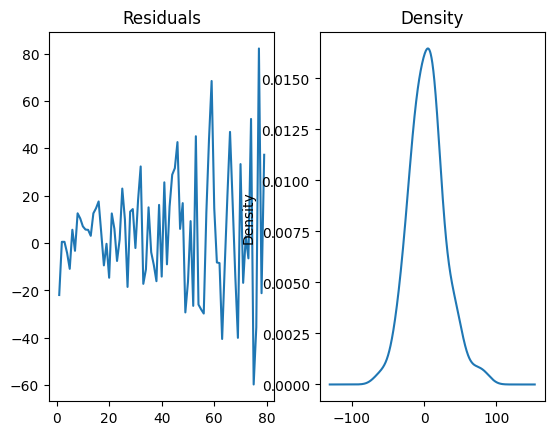

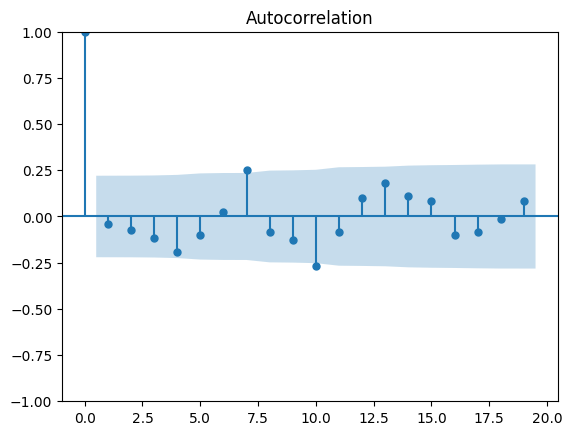

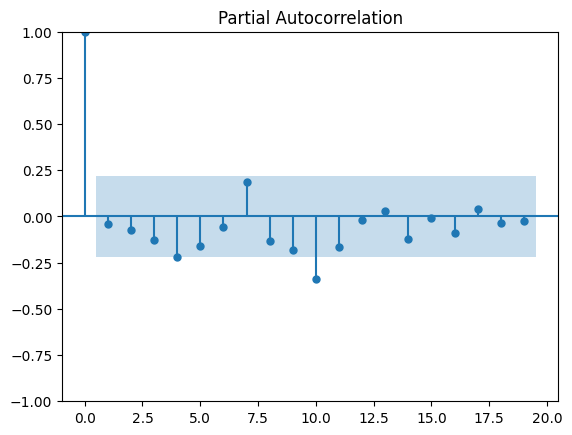

In [80]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

acf_original = plot_acf(residuals)
plt.show()

pacf_original = plot_pacf(residuals)
plt.show()

MAE: 39.09429709848589
medAE: 35.59643533687918
MSE: 2198.4598849374343
MSLE: 0.03704471783345501
MAPE: 15.868139977738775


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='ProductP2'>)

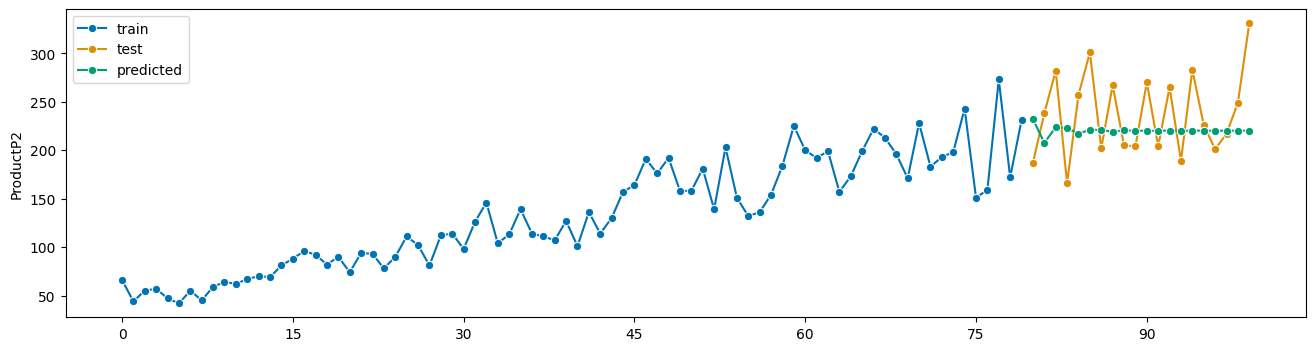

In [109]:
forecast = model_fit.forecast(steps = len(df_test['ProductP2']))
predicted_values = forecast

get_metrics(df_test['ProductP2'], forecast)

plot_series(df_train['ProductP2'], df_test['ProductP2'], predicted_values, labels = ['train', 'test', 'predicted'])

Epoch 1/1000
73/73 [==============================] - 5s 14ms/step - loss: 4588.2827 - mae: 51.8315 - val_loss: 2064.6104 - val_mae: 39.8047
Epoch 2/1000
73/73 [==============================] - 1s 8ms/step - loss: 850.4772 - mae: 22.3901 - val_loss: 1839.1881 - val_mae: 36.8092
Epoch 3/1000
73/73 [==============================] - 1s 9ms/step - loss: 958.5206 - mae: 23.7829 - val_loss: 1847.8308 - val_mae: 36.9986
Epoch 4/1000
73/73 [==============================] - 1s 7ms/step - loss: 852.9682 - mae: 22.7165 - val_loss: 3075.4810 - val_mae: 47.2985
Epoch 5/1000
73/73 [==============================] - 1s 8ms/step - loss: 933.1724 - mae: 23.7581 - val_loss: 1859.1213 - val_mae: 37.2396
Epoch 6/1000
73/73 [==============================] - 1s 7ms/step - loss: 829.9257 - mae: 21.5792 - val_loss: 1882.0381 - val_mae: 36.2645
Epoch 7/1000
73/73 [==============================] - 1s 7ms/step - loss: 758.6468 - mae: 21.5992 - val_loss: 1879.2235 - val_mae: 36.9019
Epoch 8/1000
73/73 [=====

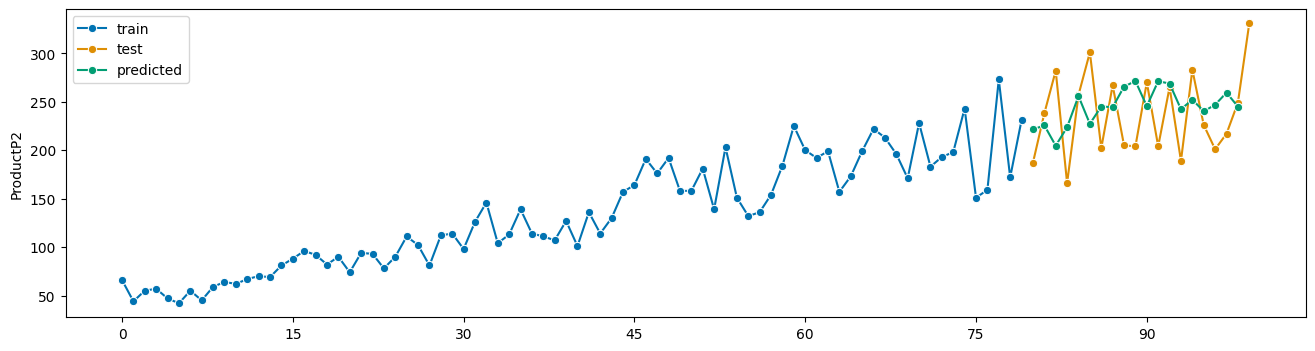

In [89]:
data = df['ProductP2']
data = data.values.reshape(-1, 1)

time_steps = 8
n_neurons = 16

# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

X, y = [], []
for i in range(len(data) - time_steps):
    X.append(data[i : (i + time_steps), 0])
    y.append(data[i + time_steps, 0])

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(units = n_neurons, return_sequences = True, input_shape = (time_steps, 1), activation = 'relu'))
model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'relu'))
# model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'relu'))
# model.add(LSTM(units = n_neurons, return_sequences = True, activation = 'relu'))
model.add(LSTM(units = n_neurons, return_sequences = False, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 11, restore_best_weights = True)

model.fit(X_train, y_train, epochs = 1000, batch_size = 1, validation_data = [X_test, y_test], callbacks = [early_stopping])

predicted_values = model.predict(X_test)

plot_series(df_train['ProductP2'], df_test['ProductP2'], 
            pd.Series(predicted_values.flatten(), index = range(80, 99)), 
            labels = ['train', 'test', 'predicted'])

get_metrics(y_test, predicted_values)
# print(np.mean(np.abs((y_test - predicted_values) / y_test)) * 100)

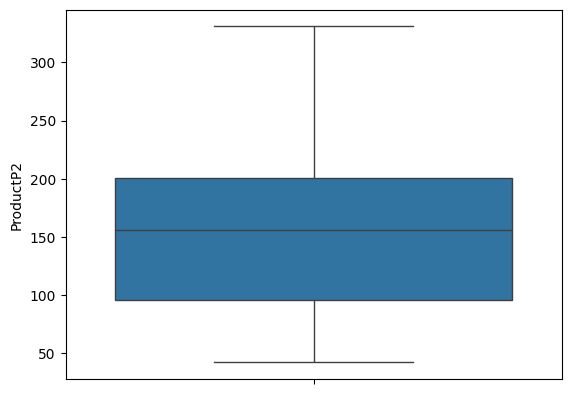

In [90]:
sns.boxplot(df['ProductP2'])
plt.show()

In [113]:
class Model():
    def __init__(self, n_layers = 2, n_neurons = 16, if_scale = False, time_steps = 8):
        self.data = df['ProductP2']
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.if_scale = if_scale
        self.time_steps = time_steps

    
    def get_params(self, deep = True):
        return {
            'n_layers': self.n_layers,
            'n_neurons': self.n_neurons,
            'if_scale': self.if_scale,
            'time_steps': self.time_steps
        }
    
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    
    def create_model(self): 
        data = self.data.values.reshape(-1, 1)

        if self.if_scale == 1:
            scaler = MinMaxScaler()
            data = scaler.fit_transform(data)

        X, y = [], []
        for i in range(len(data) - self.time_steps):
            X.append(data[i : (i + self.time_steps), 0])
            y.append(data[i + self.time_steps, 0])

        X, y = np.array(X), np.array(y)

        split = int(0.8 * len(X))
        self.X_train, self.X_test = X[:split], X[split:]
        self.y_train, self.y_test = y[:split], y[split:]

        self.X_train = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)

        self.model = Sequential()
        if self.n_layers == 1:
            self.model.add(LSTM(units = self.n_neurons, return_sequences = False, input_shape = (self.time_steps, 1), activation = 'relu'))
        else:
            self.model.add(LSTM(units = self.n_neurons, return_sequences = True, input_shape = (self.time_steps, 1), activation = 'relu'))
            for i in range(self.n_layers - 2):
                self.model.add(LSTM(units = self.n_neurons, return_sequences = True, activation = 'relu'))

            self.model.add(LSTM(units = self.n_neurons, return_sequences = False, activation = 'relu'))


        self.model.add(Dense(units = 1, activation = 'linear'))
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

    
    def fit(self, X, y):
        self.create_model()
        print(f"n_layers = {self.n_layers}, n_neurons = {self.n_neurons}, if_scale = {self.if_scale}, time_steps = {self.time_steps}.")
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 11, restore_best_weights = True)
        self.model.fit(self.X_train, 
                  self.y_train, 
                  epochs = 1000, 
                  batch_size = 1, 
                  validation_data = [self.X_train, self.y_train], 
                  callbacks = [early_stopping], 
                  verbose = False)

        predicted_values = self.model.predict(self.X_train)
        return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


    def score(self, X, y):
        self.model.predict(self.X_test)
        predicted_values = self.model.predict(self.X_test)
        print(f"MAPE: {np.mean(np.abs((self.y_test - predicted_values) / self.y_test)) * 100}\n")
        return -np.mean(np.abs((self.y_test - predicted_values) / self.y_test)) * 100

In [92]:
param_dist = {
    'n_layers': np.arange(1, 7, 1),
    'n_neurons' : np.arange(4, 65, 1),
    'if_scale' : [0, 1],
    'time_steps' : np.arange(2, 17, 1)
}

random_search = RandomizedSearchCV(Model(), param_distributions = param_dist, n_iter = 25, cv = 2)

random_search.fit(np.zeros((10, 10)), np.zeros(10))

best_params = random_search.best_params_
print("Best Parameters:", best_params, '\n\n\n\n\n')

cv_results = random_search.cv_results_
for i in range(len(cv_results['params'])):
    print(f"Iteration {i + 1} - Parameters: {cv_results['params'][i]}, Mean Test Score: {cv_results['mean_test_score'][i]}\n")

n_layers = 6, n_neurons = 13, if_scale = 0, time_steps = 15.
1/1 [==============================] - 0s 50ms/step
MAPE: 19.21125281191197

n_layers = 6, n_neurons = 13, if_scale = 0, time_steps = 15.
1/1 [==============================] - 0s 29ms/step
MAPE: 15.15112992775327

n_layers = 2, n_neurons = 32, if_scale = 1, time_steps = 7.
1/1 [==============================] - 0s 31ms/step
MAPE: 18.893728228786067

n_layers = 2, n_neurons = 32, if_scale = 1, time_steps = 7.
1/1 [==============================] - 0s 26ms/step
MAPE: 18.81058647687531

n_layers = 5, n_neurons = 60, if_scale = 0, time_steps = 6.
1/1 [==============================] - 0s 35ms/step
MAPE: 15.806866914595382

n_layers = 5, n_neurons = 60, if_scale = 0, time_steps = 6.
1/1 [==============================] - 0s 23ms/step
MAPE: 17.67935115198796

n_layers = 5, n_neurons = 24, if_scale = 1, time_steps = 15.
1/1 [==============================] - 0s 25ms/step
MAPE: 19.62860668450551

n_layers = 5, n_neurons = 24, if_sca

/tmp/ipykernel_22997/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


n_layers = 4, n_neurons = 14, if_scale = 1, time_steps = 5.
1/1 [==============================] - 0s 22ms/step
MAPE: 18.815434336410306



/tmp/ipykernel_22997/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


n_layers = 3, n_neurons = 6, if_scale = 1, time_steps = 3.
1/1 [==============================] - 0s 21ms/step
MAPE: 18.79066918212458



/tmp/ipykernel_22997/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


n_layers = 3, n_neurons = 6, if_scale = 1, time_steps = 3.
1/1 [==============================] - 0s 22ms/step
MAPE: 19.45292105264025



/tmp/ipykernel_22997/4273635701.py:74: RuntimeWarning: divide by zero encountered in divide
  return -np.mean(np.abs((self.y_train - predicted_values) / self.y_train)) * 100


n_layers = 4, n_neurons = 9, if_scale = 1, time_steps = 15.
1/1 [==============================] - 0s 22ms/step
MAPE: 23.020061144228794

n_layers = 4, n_neurons = 9, if_scale = 1, time_steps = 15.
1/1 [==============================] - 0s 24ms/step
MAPE: 18.905085357002253

n_layers = 5, n_neurons = 49, if_scale = 0, time_steps = 12.
1/1 [==============================] - 0s 28ms/step
MAPE: 18.17027358786582

n_layers = 5, n_neurons = 49, if_scale = 0, time_steps = 12.
1/1 [==============================] - 0s 28ms/step
MAPE: 19.148563689890075

n_layers = 2, n_neurons = 44, if_scale = 0, time_steps = 8.
1/1 [==============================] - 0s 19ms/step
MAPE: 16.425038674363982

n_layers = 2, n_neurons = 44, if_scale = 0, time_steps = 8.
1/1 [==============================] - 0s 23ms/step
MAPE: 15.525957240593339

n_layers = 6, n_neurons = 28, if_scale = 0, time_steps = 15.
1/1 [==============================] - 0s 30ms/step
MAPE: 17.174306218521345

n_layers = 6, n_neurons = 28, if

In [114]:
model = Model(3, 14, 0, 4)
model.fit(np.zeros((10, 10)), np.zeros(10))

n_layers = 3, n_neurons = 14, if_scale = 0, time_steps = 4.
3/3 [==============================] - 1s 8ms/step


-53.027908027774075

1/1 [==============================] - 0s 75ms/step


MAE: 43.320213317871094
medAE: 34.933685302734375
MSE: 2850.7528293251294
MSLE: 0.048893228843390424
MAPE: 16.08124013384571


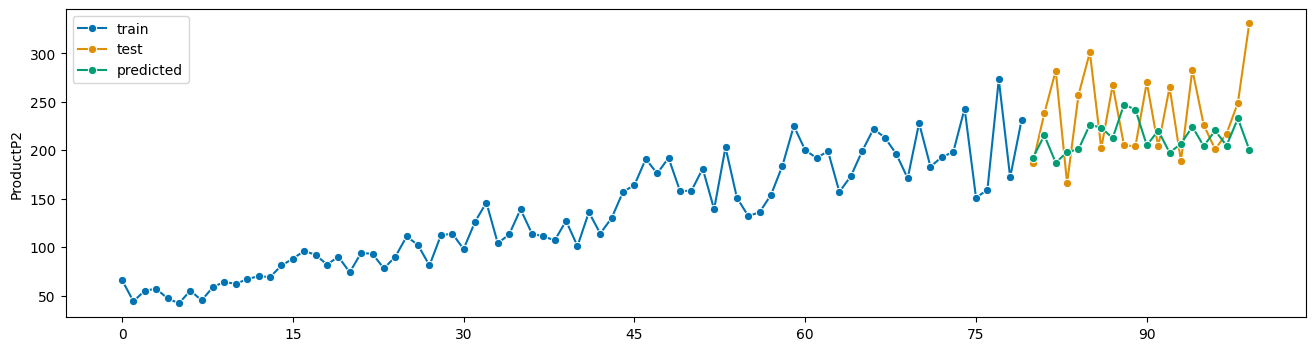

In [115]:
X_test = model.X_test
y_test = model.y_test
model = model.model

predicted_values = model.predict(X_test)

plot_series(df_train['ProductP2'], df_test['ProductP2'], 
            pd.Series(predicted_values.flatten(), index = range(80, 100)), 
            labels = ['train', 'test', 'predicted'])

get_metrics(y_test, predicted_values)